<a href="https://colab.research.google.com/github/prakritipaul/mhcglobe/blob/main/prakriti_MHCglobe_code_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Checking if my implementation that draws upon Eric's individual functions is correct

Current implementation: v1_troubleshoot_MHCGlobe_pipeline

1. Load all individual models
2. Train all of them on the entire database (just check that example data is not in here- I see there is overlap!!)
3. Predict each one on example data
4. Take the average
5. It should line up with what Eric has in the workflow

In [1]:
!git clone https://github.com/prakritipaul/mhcglobe.git

Cloning into 'mhcglobe'...
remote: Enumerating objects: 707, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 707 (delta 90), reused 63 (delta 24), pack-reused 549
Receiving objects: 100% (707/707), 112.58 MiB | 24.58 MiB/s, done.
Resolving deltas: 100% (388/388), done.
Updating files: 100% (197/197), done.
Error downloading object: data/distB62_unique_pseudpsequences.pkl (d151a08): Smudge error: Error downloading data/distB62_unique_pseudpsequences.pkl (d151a0800777499690d258210735bbe1bf8f627fedc59b579281582b6a03b3da): batch response: This repository is over its data quota. Account responsible for LFS bandwidth should purchase more data packs to restore access.

Errors logged to /content/mhcglobe/.git/lfs/logs/20240326T194441.951959962.log
Use `git lfs logs last` to view the log.
error: external filter 'git-lfs filter-process' failed
fatal: data/distB62_unique_pseudpsequences.pkl: smudge filter lfs failed
You can in

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sys
sys.path.append("/content/mhcglobe/src")

### Get data
Contains both BA+EL, human and non-human

In [3]:
import mhc_data
# 729,538/1,229,838
pMHC_true = mhc_data.pMHC_Data(only_EL=False, drop_duplicate_records=True)
pMHC_true_data = pMHC_true.data
# pMHC_true_data.shape

### Get 4 relevant columns

In [4]:
pMHC_true_data = pMHC_true_data[["allele", "peptide", "measurement_inequality", "measurement_value"]]
# pMHC_true_data.head()

### Make X_tr, Y_tr, X_es, Y_es for training

In [5]:
import mhcglobe
# loads the init model
ensemble = mhcglobe.ensemble(train_type="init")
# DOES depend on init/full!
setup_data_training = ensemble.setup_data_training(pMHC_true_data)
# I don't think this is deterministic
X_tr, Y_tr, X_es, Y_es = setup_data_training

### Load base tensorflow models individually and train
Idea is that these trained models should be equivalent to full models that are loaded into the ensemble, and used for final predictions.

In [6]:
import train_functions as trainf
model_dir = "/content/mhcglobe/model/mhcglobe/init/"

model_1 = trainf.load_trained_mhcglobe_model(model_path=model_dir+"model14_fold13_ONE_HOT_init/")
model_2 = trainf.load_trained_mhcglobe_model(model_path=model_dir+"model37_fold15_ONE_HOT_init/")
model_3 = trainf.load_trained_mhcglobe_model(model_path=model_dir+"model79_fold9_ONE_HOT_init/")

In [7]:
new_model_path, verbose = "/content/mhcglobe/outputs", 0
init_model = model_1
new_model_1 = trainf.train_mhcglobe_model(init_model, X_tr, Y_tr, X_es, Y_es, new_model_path, verbose)

In [8]:
new_model_path, verbose = "/content/mhcglobe/outputs", 0
init_model = model_2
new_model_2 = trainf.train_mhcglobe_model(init_model, X_tr, Y_tr, X_es, Y_es, new_model_path, verbose)

In [9]:
new_model_path, verbose = "/content/mhcglobe/outputs", 0
init_model = model_3
new_model_3 = trainf.train_mhcglobe_model(init_model, X_tr, Y_tr, X_es, Y_es, new_model_path, verbose)

### Predict individually on example data

In [10]:
example_binding_data = '/content/mhcglobe/example/example_binding_data.csv'
# prediction_cols = ['allele', 'peptide']
example_data = pd.read_csv(example_binding_data)
# example_data

In [11]:
# prediction 1
import sequence_functions as seqf
import binding_affinity as ba

to_predict = example_data
X = seqf.get_XY(to_predict, encode_type="ONE_HOT", get_Y=False)


In [12]:
def get_prediction_df(new_model, X, to_predict):
  mhcglobe_scores = new_model.predict(X)

  # Get them
  mhcglobe_scores = mhcglobe_scores.flatten()
  mhcglobe_affinities = list(map(ba.to_ic50, mhcglobe_scores))

  prediction_dict = {"mhcglobe_scores": mhcglobe_scores, "mhcglobe_affinities": mhcglobe_affinities}
  prediction_df = pd.DataFrame(prediction_dict)

  # Munge to_predict so I can correctly concatenate the columns
  munged_to_predict = to_predict
  munged_to_predict.index = prediction_df.index

  # Present the data nicely!
  prediction_df_all = pd.concat([munged_to_predict, prediction_df], axis=1)
  return(prediction_df_all)


In [13]:
prediction_df_1 = get_prediction_df(new_model_1, X, to_predict)
prediction_df_1

4/4 [==============================] - 0s 13ms/step


,allele,peptide,measurement_inequality,measurement_value,mhcglobe_scores,mhcglobe_affinities
0,HLA-B*15:01,AQMWSLMYF,=,0.330000,0.546333,135.446165
1,HLA-A*33:01,DIDILQTNSR,=,314.000000,0.480532,276.035726
2,HLA-B*38:01,QPKKAAAAL,>,20000.000000,0.462519,335.433508
3,HLA-A*31:01,FLALGFFLR,=,43.000000,0.553559,125.259803
4,HLA-B*07:02,RPQKRPSCI,=,7.819348,0.532826,156.761086
...,...,...,...,...,...,...
95,HLA-A*30:01,KAFNHASVK,=,34.700000,0.571513,103.145255
96,HLA-A*02:01,WMMAMKYPI,=,54.000000,0.475197,292.437494
97,HLA-A*02:03,FLMGFNRDV,=,1.000000,0.569263,105.686698
98,HLA-A*02:01,LLSTTEWQV,=,67.000000,0.583336,90.759292


In [14]:
prediction_df_2 = get_prediction_df(new_model_2, X, to_predict)
prediction_df_2

4/4 [==============================] - 0s 3ms/step


,allele,peptide,measurement_inequality,measurement_value,mhcglobe_scores,mhcglobe_affinities
0,HLA-B*15:01,AQMWSLMYF,=,0.330000,0.622412,59.466761
1,HLA-A*33:01,DIDILQTNSR,=,314.000000,0.531788,158.531097
2,HLA-B*38:01,QPKKAAAAL,>,20000.000000,0.065373,24648.028717
3,HLA-A*31:01,FLALGFFLR,=,43.000000,0.610430,67.698470
4,HLA-B*07:02,RPQKRPSCI,=,7.819348,0.571891,102.723456
...,...,...,...,...,...,...
95,HLA-A*30:01,KAFNHASVK,=,34.700000,0.601244,74.772526
96,HLA-A*02:01,WMMAMKYPI,=,54.000000,0.731302,18.306528
97,HLA-A*02:03,FLMGFNRDV,=,1.000000,0.692482,27.862287
98,HLA-A*02:01,LLSTTEWQV,=,67.000000,0.607948,69.541031


In [15]:
prediction_df_3 = get_prediction_df(new_model_3, X, to_predict)
prediction_df_3

4/4 [==============================] - 0s 3ms/step


,allele,peptide,measurement_inequality,measurement_value,mhcglobe_scores,mhcglobe_affinities
0,HLA-B*15:01,AQMWSLMYF,=,0.330000,0.644345,46.904195
1,HLA-A*33:01,DIDILQTNSR,=,314.000000,0.482117,271.342846
2,HLA-B*38:01,QPKKAAAAL,>,20000.000000,0.149722,9895.302846
3,HLA-A*31:01,FLALGFFLR,=,43.000000,0.488817,252.367575
4,HLA-B*07:02,RPQKRPSCI,=,7.819348,0.575988,98.270158
...,...,...,...,...,...,...
95,HLA-A*30:01,KAFNHASVK,=,34.700000,0.632794,53.148155
96,HLA-A*02:01,WMMAMKYPI,=,54.000000,0.865438,4.288483
97,HLA-A*02:03,FLMGFNRDV,=,1.000000,0.804040,8.333194
98,HLA-A*02:01,LLSTTEWQV,=,67.000000,0.642271,47.968821


### Get average results

In [16]:
# Average mhcglobe_scores
mhcglobe_affinities_df1 = prediction_df_1['mhcglobe_affinities']
mhcglobe_affinities_df2 = prediction_df_2['mhcglobe_affinities']
mhcglobe_affinities_df3 = prediction_df_3['mhcglobe_affinities']

In [17]:
average_mhcglobe_affinities = (mhcglobe_affinities_df1 + mhcglobe_affinities_df2 + mhcglobe_affinities_df3) / 3

In [18]:
average_mhcglobe_affinities

0        80.605707
1       235.303223
2     11626.255024
3       148.441949
4       119.251567
          ...     
95       77.021979
96      105.010835
97       47.294060
98       69.423048
99       88.982411
Name: mhcglobe_affinities, Length: 100, dtype: float64

### Compare with true values

In [35]:
prediction_df_comparison = example_data
prediction_df_comparison["predicted_mhcglob_affinities"] = average_mhcglobe_affinities
prediction_df_comparison

,allele,peptide,measurement_inequality,measurement_value,predicted_mhcglob_affinities
0,HLA-B*15:01,AQMWSLMYF,=,0.330000,80.605707
1,HLA-A*33:01,DIDILQTNSR,=,314.000000,235.303223
2,HLA-B*38:01,QPKKAAAAL,>,20000.000000,11626.255024
3,HLA-A*31:01,FLALGFFLR,=,43.000000,148.441949
4,HLA-B*07:02,RPQKRPSCI,=,7.819348,119.251567
...,...,...,...,...,...
95,HLA-A*30:01,KAFNHASVK,=,34.700000,77.021979
96,HLA-A*02:01,WMMAMKYPI,=,54.000000,105.010835
97,HLA-A*02:03,FLMGFNRDV,=,1.000000,47.294060
98,HLA-A*02:01,LLSTTEWQV,=,67.000000,69.423048


In [33]:
df_filtered = prediction_df_comparison[[col for col in prediction_df_comparison.columns if col != 'measurement_inequality']]
print(df_filtered)

         allele     peptide  measurement_value  predicted_mhcglob_affinities
0   HLA-B*15:01   AQMWSLMYF           0.330000                     80.605707
1   HLA-A*33:01  DIDILQTNSR         314.000000                    235.303223
2   HLA-B*38:01   QPKKAAAAL       20000.000000                  11626.255024
3   HLA-A*31:01   FLALGFFLR          43.000000                    148.441949
4   HLA-B*07:02   RPQKRPSCI           7.819348                    119.251567
..          ...         ...                ...                           ...
95  HLA-A*30:01   KAFNHASVK          34.700000                     77.021979
96  HLA-A*02:01   WMMAMKYPI          54.000000                    105.010835
97  HLA-A*02:03   FLMGFNRDV           1.000000                     47.294060
98  HLA-A*02:01   LLSTTEWQV          67.000000                     69.423048
99  HLA-A*02:02  VLKEGSEYRV           7.870000                     88.982411

[100 rows x 4 columns]


### Plot + Get r^2

In [20]:
import matplotlib.pyplot as plt
def make_scatter_plot(df, x_col, y_col):
  plt.scatter(df[x_col], df[y_col])
  plt.xlabel(x_col)
  plt.ylabel(y_col)
  plt.title("Scatter Plot")
  plt.show()

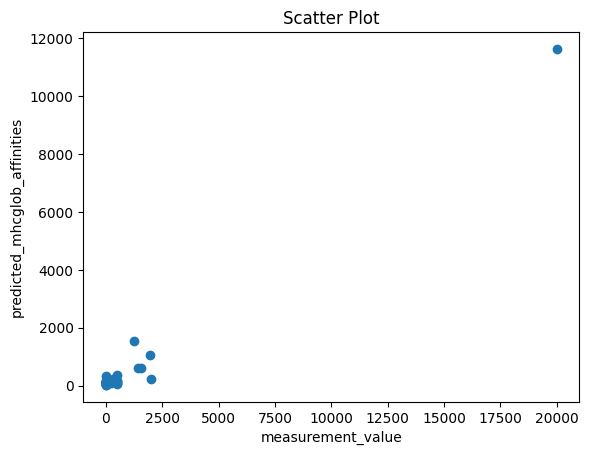

In [21]:
make_scatter_plot(prediction_df_comparison, "measurement_value", "predicted_mhcglob_affinities")

In [22]:
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error

def get_r_squared_mse(df, x_col, y_col):
  slope, intercept, r_value, p_value, std_err = linregress(df[x_col], df[y_col])
  mse = mean_squared_error(df[x_col], df[y_col])
  return(r_value**2, mse)

In [23]:
my_predictions_r, my_predictions_mse = get_r_squared_mse(prediction_df_comparison, "measurement_value", "predicted_mhcglob_affinities")
print("R-squared:", my_predictions_r)
print("MSE:", my_predictions_mse)

R-squared: 0.983656915603968
MSE: 771510.2038623607


## How did Eric do?
Amazingly!!!

Note: Good, this is reproducible!

In [24]:
# Load MHCGlobe class object containing the fully trained model.
mhcglobe_model = mhcglobe.ensemble(train_type='full')

# Load binding data as CSV. Required columns are `allele` and `peptide`.
example_binding_data = '/content/mhcglobe/example/example_binding_data.csv'
prediction_cols = ['allele', 'peptide']
# pMHC_data = pd.read_csv(example_binding_data, usecols=prediction_cols)
example_data = pd.read_csv(example_binding_data)

# Predict peptide-MHC binding with MHCGlobe
eric_predictions = mhcglobe_model.predict_on_dataframe(example_data)

In [25]:
eric_predictions

,allele,peptide,measurement_inequality,measurement_value,mhcglobe_affinity,mhcglobe_score
0,HLA-B*15:01,AQMWSLMYF,=,0.330000,64.439289,0.614990
1,HLA-A*33:01,DIDILQTNSR,=,314.000000,396.717038,0.447011
2,HLA-B*38:01,QPKKAAAAL,>,20000.000000,20009.976327,0.084641
3,HLA-A*31:01,FLALGFFLR,=,43.000000,117.473925,0.559490
4,HLA-B*07:02,RPQKRPSCI,=,7.819348,104.042288,0.570712
...,...,...,...,...,...,...
95,HLA-A*30:01,KAFNHASVK,=,34.700000,118.069387,0.559023
96,HLA-A*02:01,WMMAMKYPI,=,54.000000,61.744092,0.618939
97,HLA-A*02:03,FLMGFNRDV,=,1.000000,30.050617,0.685494
98,HLA-A*02:01,LLSTTEWQV,=,67.000000,91.183992,0.582905


### Plot + Get r^2

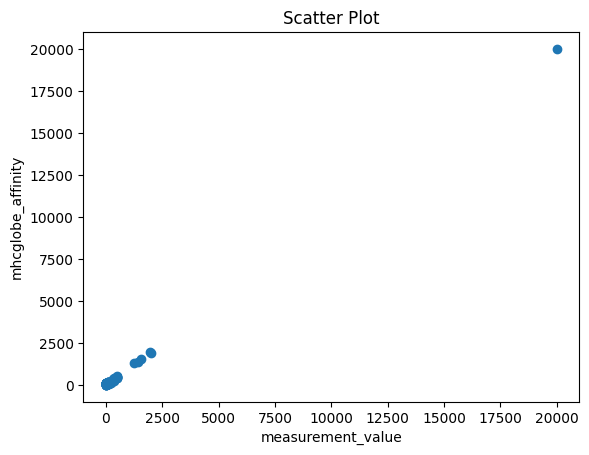

In [26]:
make_scatter_plot(eric_predictions, "measurement_value", "mhcglobe_affinity")

In [27]:
eric_predictions_r, eric_predictions_mse = get_r_squared_mse(eric_predictions, "measurement_value", "mhcglobe_affinity")
print("R-squared:", eric_predictions_r)
print("MSE:", eric_predictions_mse)

R-squared: 0.9994910366115101
MSE: 4199.057414035893


### Take a look at BA

In [28]:
eric_predictions_subset = eric_predictions[eric_predictions['measurement_inequality'] == '=']
eric_predictions_subset

,allele,peptide,measurement_inequality,measurement_value,mhcglobe_affinity,mhcglobe_score
0,HLA-B*15:01,AQMWSLMYF,=,0.330000,64.439289,0.614990
1,HLA-A*33:01,DIDILQTNSR,=,314.000000,396.717038,0.447011
3,HLA-A*31:01,FLALGFFLR,=,43.000000,117.473925,0.559490
4,HLA-B*07:02,RPQKRPSCI,=,7.819348,104.042288,0.570712
5,HLA-A*31:01,RIGGVLIFR,=,11.000000,81.121732,0.593712
...,...,...,...,...,...,...
95,HLA-A*30:01,KAFNHASVK,=,34.700000,118.069387,0.559023
96,HLA-A*02:01,WMMAMKYPI,=,54.000000,61.744092,0.618939
97,HLA-A*02:03,FLMGFNRDV,=,1.000000,30.050617,0.685494
98,HLA-A*02:01,LLSTTEWQV,=,67.000000,91.183992,0.582905


In [29]:
eric_predictions_subset_r, eric_predictions_subset_mse = get_r_squared_mse(eric_predictions_subset, "measurement_value", "mhcglobe_affinity")
print("R-squared:", eric_predictions_subset_r)
print("MSE:", eric_predictions_subset_mse)

R-squared: 0.9891813856229511
MSE: 4515.2827426143895
